Text(0, 0.5, 'Cycle life')

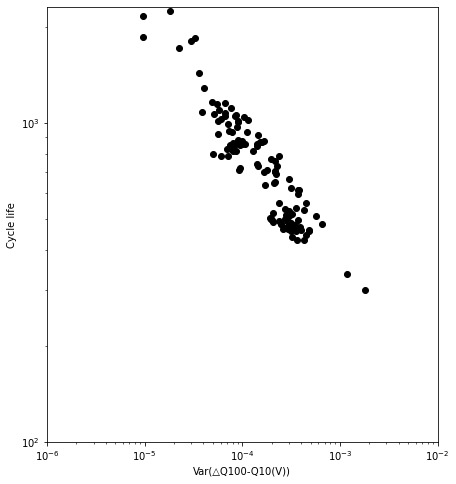

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

# Train(41)_ Test(42) Split

In [131]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [132]:
np.random.seed(42)
threshold = 550

In [133]:
def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,31):
        for j in range(1,30):
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_
            


In [134]:
i_, j_ =i_j_make()

In [135]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        if cycle_test[0][0]>=threshold:
            test_label.append(1)
        else:
            test_label.append(0)
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        if cycle_train[0][0]>=threshold:
            train_label.append(1)
        else:
            train_label.append(0)
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        if cycle_sec[0][0]>=threshold:
            sec_label.append(1)
        else:
            sec_label.append(0)

In [136]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)


In [137]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape, sec_data.shape, sec_label.shape

((41,), (41,), (42,), (42,), (36,), (36,))

In [138]:
unique, counts = np.unique(train_label, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_label, return_counts=True)
print(unique, counts)
unique, counts = np.unique(sec_label, return_counts=True)
print(unique, counts)

[0 1] [21 20]
[0 1] [20 22]
[0 1] [ 1 35]


In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
def logistic_auc(X,Y,boot_trainX,boot_trainY,boot_testX,boot_testY): #학습은 train data 로 진행 하고 predict는 랜덤 데이터 얻기
    global var,var_test,var_sec

    
    Log_reg = LogisticRegression()
    x=X.reshape(-1,1)
    Log_reg.fit(x,Y)
    train_X=boot_trainX.reshape(-1,1)
    test_X=boot_testX.reshape(-1,1)

    AUC_train=roc_auc_score(boot_trainY, Log_reg.decision_function(train_X))
    AUC_test=roc_auc_score(boot_testY, Log_reg.decision_function(test_X))
    
    coef_info=Log_reg.coef_
    
    pred_train=Log_reg.predict(var.reshape(-1,1))
    at=accuracy_score(Y,pred_train)
    pred_test=Log_reg.predict(var_test.reshape(-1,1))
    apt=accuracy_score(test_label,pred_test)
    pred_sec=Log_reg.predict(var_sec.reshape(-1,1))
    ast=accuracy_score(sec_label,pred_sec)
    
    conf_train=confusion_matrix(Y,pred_train)
    conf_test=confusion_matrix(test_label,pred_test)
    conf_sec=confusion_matrix(sec_label,pred_sec)
    
    return AUC_train, AUC_test,coef_info,conf_train,conf_test,conf_sec, at , apt, ast



Pipeline 사용하면 더 쉽겠다(Full classifier에서 만들자)

In [140]:
#train(i*j) AUC 구하기
mx_train=np.full((30,31),0.5)
mx_test=np.full((30,31),0.5)
coef=[]
conf=[]
at_apt_ast=[]
for i,j in zip(i_,j_):
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])
    print(var_.shape,var_test_.shape,var_sec_.shape)
    
    
    
    #데이터 정규화.
    scaler = StandardScaler() 
    var = scaler.fit_transform(np.log(var_).reshape(-1,1))
    var_test = scaler.transform(np.log(var_test_).reshape(-1,1))
    var_sec = scaler.transform(np.log(var_sec_).reshape(-1,1))   



    boot_select_train=len(var)
    boot_select_test=len(var_test)
    
    boot_sample=20
    
    train_range= range(0,boot_select_train) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,boot_select_test)
    
    AUC_mean_train=[]
    AUC_mean_test=[]
    
    for _ in range(boot_sample):
        np.random.seed(42)
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=np.array([])
        random_trainY=np.array([])
        random_testX=np.array([])
        random_testY=np.array([])
        for n in sample_n:
            random_trainX=np.hstack([random_trainX,np.array(var[n])])
            random_trainY=np.hstack([random_trainY,np.array([train_label[n]])])
        for n in sample_test:
            random_testX=np.hstack([random_testX,np.array(var_test[n])])
            random_testY=np.hstack([random_testY,np.array([test_label[n]])])
        auc_train,auc_test,coef_,conf_train,conf_test,conf_sec, at , apt, ast=logistic_auc(
            var,train_label,random_trainX,random_trainY,random_testX,random_testY)
        AUC_mean_train.append(auc_train)
        AUC_mean_test.append(auc_test)
    print('i={},j={}   AUC_train= '.format(i,j),np.mean(AUC_mean_train))
    print('i={},j={}   AUC_test= '.format(i,j),np.mean(AUC_mean_test))
    print('\n')
    mx_train[j,i]= np.mean(AUC_mean_train)
    mx_test[j,i]= np.mean(AUC_mean_test)
    if i==5 and j==4 :
        coef.append(coef_)
        conf.append(conf_train)
        conf.append(conf_test)
        conf.append(conf_sec)
        at_apt_ast.append(at)
        at_apt_ast.append(apt)
        at_apt_ast.append(ast)

(41,) (42,) (36,)
i=2,j=1   AUC_train=  0.9371980676328502
i=2,j=1   AUC_test=  0.5879629629629631


(41,) (42,) (36,)
i=3,j=1   AUC_train=  0.9637681159420287
i=3,j=1   AUC_test=  0.8032407407407408


(41,) (42,) (36,)
i=3,j=2   AUC_train=  0.9323671497584544
i=3,j=2   AUC_test=  0.9027777777777779


(41,) (42,) (36,)
i=4,j=1   AUC_train=  0.8429951690821257
i=4,j=1   AUC_test=  0.6574074074074077


(41,) (42,) (36,)
i=4,j=2   AUC_train=  0.8333333333333334
i=4,j=2   AUC_test=  0.826388888888889


(41,) (42,) (36,)
i=4,j=3   AUC_train=  0.9806763285024156
i=4,j=3   AUC_test=  0.7777777777777779


(41,) (42,) (36,)
i=5,j=1   AUC_train=  0.8164251207729467
i=5,j=1   AUC_test=  0.27083333333333326


(41,) (42,) (36,)
i=5,j=2   AUC_train=  0.567632850241546
i=5,j=2   AUC_test=  0.6412037037037038


(41,) (42,) (36,)
i=5,j=3   AUC_train=  0.6884057971014492
i=5,j=3   AUC_test=  0.6319444444444444


(41,) (42,) (36,)
i=5,j=4   AUC_train=  0.9178743961352656
i=5,j=4   AUC_test=  0.7245370370

i=14,j=4   AUC_train=  0.9637681159420287
i=14,j=4   AUC_test=  0.6226851851851851


(41,) (42,) (36,)
i=14,j=5   AUC_train=  0.8526570048309179
i=14,j=5   AUC_test=  0.4351851851851851


(41,) (42,) (36,)
i=14,j=6   AUC_train=  0.8937198067632851
i=14,j=6   AUC_test=  0.6111111111111109


(41,) (42,) (36,)
i=14,j=7   AUC_train=  0.9661835748792271
i=14,j=7   AUC_test=  0.6064814814814813


(41,) (42,) (36,)
i=14,j=8   AUC_train=  0.8671497584541065
i=14,j=8   AUC_test=  0.6111111111111109


(41,) (42,) (36,)
i=14,j=9   AUC_train=  0.8840579710144926
i=14,j=9   AUC_test=  0.6203703703703703


(41,) (42,) (36,)
i=14,j=10   AUC_train=  0.9420289855072463
i=14,j=10   AUC_test=  0.5833333333333336


(41,) (42,) (36,)
i=14,j=11   AUC_train=  0.4613526570048309
i=14,j=11   AUC_test=  0.4166666666666667


(41,) (42,) (36,)
i=14,j=12   AUC_train=  0.7028985507246375
i=14,j=12   AUC_test=  0.4884259259259259


(41,) (42,) (36,)
i=14,j=13   AUC_train=  0.9082125603864736
i=14,j=13   AUC_test=  0

i=19,j=10   AUC_train=  0.7270531400966184
i=19,j=10   AUC_test=  0.5115740740740742


(41,) (42,) (36,)
i=19,j=11   AUC_train=  0.4855072463768117
i=19,j=11   AUC_test=  0.5347222222222221


(41,) (42,) (36,)
i=19,j=12   AUC_train=  0.2971014492753623
i=19,j=12   AUC_test=  0.548611111111111


(41,) (42,) (36,)
i=19,j=13   AUC_train=  0.6159420289855074
i=19,j=13   AUC_test=  0.4814814814814814


(41,) (42,) (36,)
i=19,j=14   AUC_train=  0.6545893719806765
i=19,j=14   AUC_test=  0.659722222222222


(41,) (42,) (36,)
i=19,j=15   AUC_train=  0.9806763285024156
i=19,j=15   AUC_test=  0.9189814814814815


(41,) (42,) (36,)
i=19,j=16   AUC_train=  0.7077294685990339
i=19,j=16   AUC_test=  0.8148148148148147


(41,) (42,) (36,)
i=19,j=17   AUC_train=  0.9009661835748795
i=19,j=17   AUC_test=  0.8101851851851851


(41,) (42,) (36,)
i=19,j=18   AUC_train=  0.9710144927536236
i=19,j=18   AUC_test=  0.875


(41,) (42,) (36,)
i=20,j=1   AUC_train=  0.9637681159420287
i=20,j=1   AUC_test=  0.6620

i=23,j=13   AUC_train=  0.7681159420289856
i=23,j=13   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=23,j=14   AUC_train=  0.9082125603864736
i=23,j=14   AUC_test=  0.861111111111111


(41,) (42,) (36,)
i=23,j=15   AUC_train=  0.9371980676328502
i=23,j=15   AUC_test=  0.923611111111111


(41,) (42,) (36,)
i=23,j=16   AUC_train=  0.898550724637681
i=23,j=16   AUC_test=  0.888888888888889


(41,) (42,) (36,)
i=23,j=17   AUC_train=  0.9855072463768118
i=23,j=17   AUC_test=  0.8912037037037036


(41,) (42,) (36,)
i=23,j=18   AUC_train=  0.9202898550724639
i=23,j=18   AUC_test=  0.9120370370370372


(41,) (42,) (36,)
i=23,j=19   AUC_train=  0.9009661835748795
i=23,j=19   AUC_test=  0.8564814814814815


(41,) (42,) (36,)
i=23,j=20   AUC_train=  0.9323671497584544
i=23,j=20   AUC_test=  0.9398148148148145


(41,) (42,) (36,)
i=23,j=21   AUC_train=  0.9855072463768118
i=23,j=21   AUC_test=  0.9375000000000002


(41,) (42,) (36,)
i=23,j=22   AUC_train=  0.9589371980676331
i=23,j=22   AUC_t

i=26,j=25   AUC_train=  0.9806763285024156
i=26,j=25   AUC_test=  0.7268518518518517


(41,) (42,) (36,)
i=27,j=1   AUC_train=  0.9396135265700483
i=27,j=1   AUC_test=  0.6435185185185187


(41,) (42,) (36,)
i=27,j=2   AUC_train=  0.9251207729468597
i=27,j=2   AUC_test=  0.7129629629629631


(41,) (42,) (36,)
i=27,j=3   AUC_train=  0.9178743961352656
i=27,j=3   AUC_test=  0.7337962962962962


(41,) (42,) (36,)
i=27,j=4   AUC_train=  0.8526570048309179
i=27,j=4   AUC_test=  0.7685185185185186


(41,) (42,) (36,)
i=27,j=5   AUC_train=  0.8840579710144928
i=27,j=5   AUC_test=  0.7430555555555556


(41,) (42,) (36,)
i=27,j=6   AUC_train=  0.8913043478260867
i=27,j=6   AUC_test=  0.7129629629629631


(41,) (42,) (36,)
i=27,j=7   AUC_train=  0.6135265700483092
i=27,j=7   AUC_test=  0.6203703703703705


(41,) (42,) (36,)
i=27,j=8   AUC_train=  0.8719806763285021
i=27,j=8   AUC_test=  0.6990740740740742


(41,) (42,) (36,)
i=27,j=9   AUC_train=  0.8285024154589372
i=27,j=9   AUC_test=  0.63888

i=29,j=27   AUC_train=  0.951690821256039
i=29,j=27   AUC_test=  0.8564814814814813


(41,) (42,) (36,)
i=29,j=28   AUC_train=  0.9637681159420287
i=29,j=28   AUC_test=  0.7708333333333335


(41,) (42,) (36,)
i=30,j=1   AUC_train=  0.898550724637681
i=30,j=1   AUC_test=  0.7592592592592593


(41,) (42,) (36,)
i=30,j=2   AUC_train=  0.9154589371980675
i=30,j=2   AUC_test=  0.7986111111111109


(41,) (42,) (36,)
i=30,j=3   AUC_train=  0.9323671497584544
i=30,j=3   AUC_test=  0.8171296296296295


(41,) (42,) (36,)
i=30,j=4   AUC_train=  0.8429951690821257
i=30,j=4   AUC_test=  0.8796296296296295


(41,) (42,) (36,)
i=30,j=5   AUC_train=  0.9009661835748795
i=30,j=5   AUC_test=  0.8402777777777779


(41,) (42,) (36,)
i=30,j=6   AUC_train=  0.886473429951691
i=30,j=6   AUC_test=  0.8287037037037036


(41,) (42,) (36,)
i=30,j=7   AUC_train=  0.6714975845410629
i=30,j=7   AUC_test=  0.724537037037037


(41,) (42,) (36,)
i=30,j=8   AUC_train=  0.8961352657004831
i=30,j=8   AUC_test=  0.8148148

1. i,j 의 조합을 먼저 정의
2. train, primary test, secondary test 데이터를 나누고 각각 임계값에 따른 0,1 값으로 binary labeling 을 함.
3. 각 데이터의 i*j 조합에 따른 $var$($Q_i$-$Q_j$) 값을 train, primary test, secondary test 의 데이터에 들어가도록 함.
4. train 데이터를 기준으로 정규화를 진행.
5. 20 bootstrap samples 를 만들기 위해서 각 데이터 수만큼 랜덤으로 데이터를 뽑고 그에 따른 target을 설정.
6. logistic 회귀를 이용해서 train data로 fitting을 함.
7. 20 bootstrap samples을 통해서 train, primary test 데이터를 이용해 각 20개의 AUC를 구하고 평균을 낸다.(AUC_train, AUC_test)
8. 논문에서 소개한 i=5,j=4에서 coef_값과 confusion_matrix 를 구함 이때 (4)의 데이터와 (6)의 모델fitting을 이용해서 예측을 진행한것.

In [141]:
print(coef)
print('train\n',conf[0],'\n prim \n',conf[1],'\n sec \n',conf[2])

[array([[-1.71563352]])]
train
 [[18  3]
 [ 3 17]] 
 prim 
 [[14  6]
 [ 5 17]] 
 sec 
 [[ 0  1]
 [ 1 34]]


In [142]:
print(conf[0]+conf[1]+conf[2])

[[32 10]
 [ 9 68]]


In [143]:
print(at_apt_ast)

[0.8536585365853658, 0.7380952380952381, 0.9444444444444444]


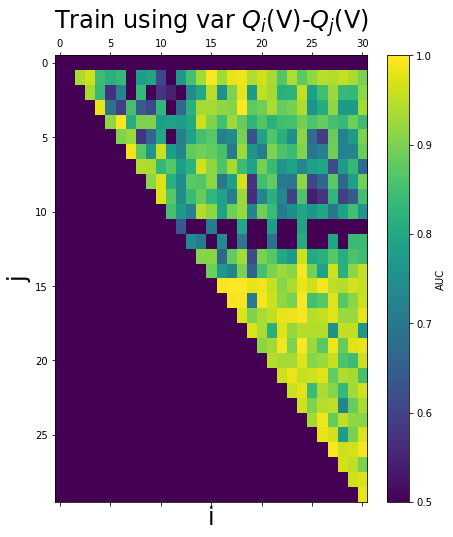

In [144]:
plt.figure(figsize=(7,8))
plt.matshow(mx_train, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Train using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

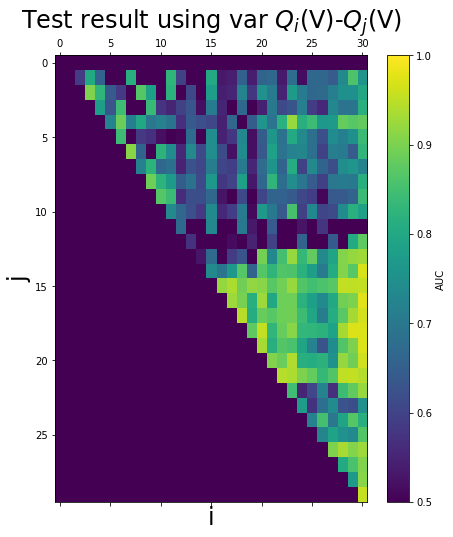

In [145]:
plt.figure(figsize=(7,8))
plt.matshow(mx_test, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar(label='AUC')
plt.xlabel('i',fontsize=24)
plt.ylabel('j',fontsize=24)
plt.title('Test result using var $Q_i$(V)-$Q_j$(V)',fontsize=24)
plt.show()

# predict_proba 평가 할 수 있다. 
# score를 통해서 평균정확도를 구할 수 있다.

# -------------------------------------- 아래는 연습과정.------------------------------------

In [22]:
threshold = 700

In [23]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        if cycle_test[0][0]>=threshold:
            test_label.append(1)
        else:
            test_label.append(0)
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        if cycle_train[0][0]>=threshold:
            train_label.append(1)
        else:
            train_label.append(0)

In [24]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)

In [25]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((41,), (41,), (42,), (42,))

In [26]:
#train(i*j) AUC 구하기
mx_train_700=np.full((30,31),0.5)
mx_test_700=np.full((30,31),0.5)
for i,j in zip(i_,j_):
    var=np.array([])
    var_test=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var=np.hstack([var,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test=np.hstack([var,np.var(diff)])
    #print(len(var))
    boot_select_train=len(var)
    boot_select_test=len(var_test)
    boot_sample=20
    train_range= range(0,41) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,42)
    AUC_mean_train=[]
    AUC_mean_test=[]
    for _ in range(boot_sample):
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=np.array([])
        random_trainY=np.array([])
        random_testX=np.array([])
        random_testY=np.array([])
        for n in sample_n:
            random_trainX=np.hstack([random_trainX,np.array([var[n]])])
            random_trainY=np.hstack([random_trainY,np.array([train_label[n]])])
        for n in sample_test:
            random_testX=np.hstack([random_testX,np.array([var_test[n]])])
            random_testY=np.hstack([random_testY,np.array([test_label[n]])])
        auc_train,auc_test=logistic_auc(var,train_label,random_trainX,random_trainY,random_testX,random_testY)
        AUC_mean_train.append(auc_train)
        AUC_mean_test.append(auc_test)
    print('i={},j={}   AUC_train= '.format(i,j),np.mean(AUC_mean_train))
    print('i={},j={}   AUC_test= '.format(i,j),np.mean(AUC_mean_test))
    print('\n')
    mx_train_700[j,i]= np.mean(AUC_mean_train)
    mx_test_700[j,i]= np.mean(AUC_mean_test)

i=2,j=1   AUC_train=  0.8492088819175075
i=2,j=1   AUC_test=  0.8595140059679375


i=3,j=1   AUC_train=  0.85170511643437
i=3,j=1   AUC_test=  0.7789626798777978


i=3,j=2   AUC_train=  0.8697915079005739
i=3,j=2   AUC_test=  0.8002384920830983


i=4,j=1   AUC_train=  0.762536589683661
i=4,j=1   AUC_test=  0.6396227353871927


i=4,j=2   AUC_train=  0.8085333631889865
i=4,j=2   AUC_test=  0.6652016385077062


i=4,j=3   AUC_train=  0.9575946072398928
i=4,j=3   AUC_test=  0.8219306097823693


i=5,j=1   AUC_train=  0.6467749896097084
i=5,j=1   AUC_test=  0.6273112859096631


i=5,j=2   AUC_train=  0.6099293489616379
i=5,j=2   AUC_test=  0.6323414787609518


i=5,j=3   AUC_train=  0.6311782253261017
i=5,j=3   AUC_test=  0.6841158774641876


i=5,j=4   AUC_train=  0.8270240586795137
i=5,j=4   AUC_test=  0.8362599130799333


i=6,j=1   AUC_train=  0.7039065726790521
i=6,j=1   AUC_test=  0.634354146648858


i=6,j=2   AUC_train=  0.5502162851577482
i=6,j=2   AUC_test=  0.44192850019819563


i=6,j=3

i=15,j=8   AUC_train=  0.9088344079667608
i=15,j=8   AUC_test=  0.8746440955558603


i=15,j=9   AUC_train=  0.8519878797902404
i=15,j=9   AUC_test=  0.7899255384130747


i=15,j=10   AUC_train=  0.8648527776273929
i=15,j=10   AUC_test=  0.8444885402814254


i=15,j=11   AUC_train=  0.7323585792071456
i=15,j=11   AUC_test=  0.710321403250485


i=15,j=12   AUC_train=  0.6447978776868163
i=15,j=12   AUC_test=  0.65998572642217


i=15,j=13   AUC_train=  0.8220935095254098
i=15,j=13   AUC_test=  0.7858135997264165


i=15,j=14   AUC_train=  0.8509376928541015
i=15,j=14   AUC_test=  0.8470750509671989


i=16,j=1   AUC_train=  0.7841790356149246
i=16,j=1   AUC_test=  0.6430917398567478


i=16,j=2   AUC_train=  0.8006062181382377
i=16,j=2   AUC_test=  0.6438688791043484


i=16,j=3   AUC_train=  0.8741902363925205
i=16,j=3   AUC_test=  0.7957786051601399


i=16,j=4   AUC_train=  0.8339675242136206
i=16,j=4   AUC_test=  0.8088516172748662


i=16,j=5   AUC_train=  0.7077793884908907
i=16,j=5   AUC_t

i=21,j=5   AUC_train=  0.9341334963668061
i=21,j=5   AUC_test=  0.9198390754002395


i=21,j=6   AUC_train=  0.9782554328474893
i=21,j=6   AUC_test=  0.9296824279456498


i=21,j=7   AUC_train=  0.8525411539861031
i=21,j=7   AUC_test=  0.7960893276060508


i=21,j=8   AUC_train=  0.9573132083818077
i=21,j=8   AUC_test=  0.9268864025728044


i=21,j=9   AUC_train=  0.8553139029667332
i=21,j=9   AUC_test=  0.844589077358291


i=21,j=10   AUC_train=  0.8638623219733059
i=21,j=10   AUC_test=  0.8048987595651512


i=21,j=11   AUC_train=  0.8117309800452042
i=21,j=11   AUC_test=  0.7370028770792134


i=21,j=12   AUC_train=  0.7847981009611821
i=21,j=12   AUC_test=  0.7462550302685892


i=21,j=13   AUC_train=  0.900240219269854
i=21,j=13   AUC_test=  0.868110769179809


i=21,j=14   AUC_train=  0.9181201020371411
i=21,j=14   AUC_test=  0.8774787378237034


i=21,j=15   AUC_train=  0.9445753561226038
i=21,j=15   AUC_test=  0.9171857545923638


i=21,j=16   AUC_train=  0.9474944251877828
i=21,j=16   A

i=25,j=15   AUC_train=  0.9336892999893571
i=25,j=15   AUC_test=  0.8806151643330195


i=25,j=16   AUC_train=  0.8152836191060233
i=25,j=16   AUC_test=  0.7957166340673606


i=25,j=17   AUC_train=  0.9133444088497764
i=25,j=17   AUC_test=  0.8482872878900031


i=25,j=18   AUC_train=  0.9388757822936713
i=25,j=18   AUC_test=  0.8944254560122211


i=25,j=19   AUC_train=  0.8280057178046359
i=25,j=19   AUC_test=  0.8215913625243022


i=25,j=20   AUC_train=  0.9245708520396028
i=25,j=20   AUC_test=  0.8926394005035508


i=25,j=21   AUC_train=  0.9312606637827058
i=25,j=21   AUC_test=  0.8911456587947818


i=25,j=22   AUC_train=  0.7037729670229751
i=25,j=22   AUC_test=  0.7185889241048615


i=25,j=23   AUC_train=  0.8343711585398893
i=25,j=23   AUC_test=  0.7566208513658366


i=25,j=24   AUC_train=  0.8675253998131909
i=25,j=24   AUC_test=  0.8343423090927123


i=26,j=1   AUC_train=  0.8898719557026007
i=26,j=1   AUC_test=  0.7846481671773443


i=26,j=2   AUC_train=  0.8476007438587798
i=2

i=29,j=9   AUC_train=  0.7314330322987612
i=29,j=9   AUC_test=  0.7811365597426128


i=29,j=10   AUC_train=  0.8666120065194001
i=29,j=10   AUC_test=  0.8504069391014262


i=29,j=11   AUC_train=  0.2602530576391796
i=29,j=11   AUC_test=  0.277245560023186


i=29,j=12   AUC_train=  0.8814447013118315
i=29,j=12   AUC_test=  0.9082072780300896


i=29,j=13   AUC_train=  0.8609603308096115
i=29,j=13   AUC_test=  0.8302299504106833


i=29,j=14   AUC_train=  0.9146944685487559
i=29,j=14   AUC_test=  0.9021385181318685


i=29,j=15   AUC_train=  0.9792968691647557
i=29,j=15   AUC_test=  0.9223316787848356


i=29,j=16   AUC_train=  0.9306679969360545
i=29,j=16   AUC_test=  0.8798174083730391


i=29,j=17   AUC_train=  0.9770785277334847
i=29,j=17   AUC_test=  0.9163011900729007


i=29,j=18   AUC_train=  0.9896245020590155
i=29,j=18   AUC_test=  0.9621332369777367


i=29,j=19   AUC_train=  0.9402995244519543
i=29,j=19   AUC_test=  0.8960652935420409


i=29,j=20   AUC_train=  0.9507206825850553
i=2

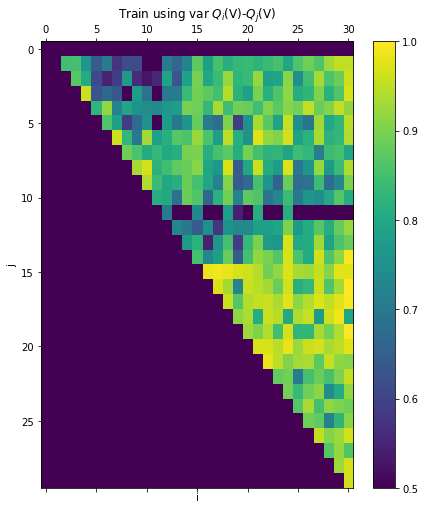

In [27]:
plt.figure(figsize=(7,8))
plt.matshow(mx_train_700, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(0.5,1)
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.title('Train using var $Q_i$(V)-$Q_j$(V)')
plt.show()

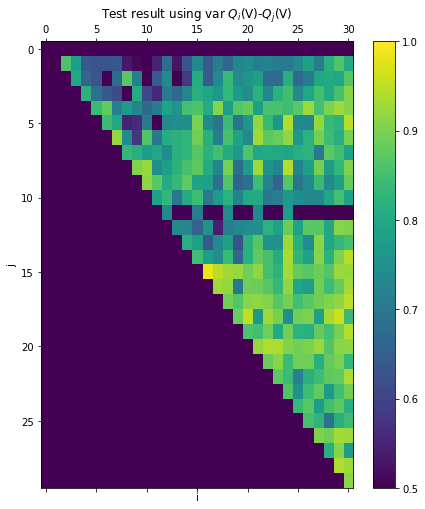

In [38]:
plt.figure(figsize=(7,8))
plt.matshow(mx_test_700, cmap=plt.cm.viridis,fignum=1,aspect='auto',vmin=0.5,vmax=1)
plt.colorbar()
plt.xlabel('i')
plt.ylabel('j')
plt.title('Test result using var $Q_i$(V)-$Q_j$(V)')
plt.show()